#### Transfer Learning (ResNet50 & EfficientNetB0)

In this notebook I:

- Use **ResNet50** and **EfficientNetB0** (pretrained on ImageNet).
- Freeze the base convolutional layers and add a custom classifier head.
- Train both models on the aerial bird vs drone dataset.
- Save the best weights.
- Export training curves for comparison with the custom CNN model.


In [1]:
import os, sys
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader_tf import get_tf_datasets
from src.models.transfer_learning_tf import (
    build_resnet50_model,
    build_efficientnetb0_model,
)


In [2]:
from pathlib import Path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

# make project root importable
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader_tf import get_tf_datasets
from src.models.transfer_learning_tf import (
    build_resnet50_model,
    build_efficientnetb0_model,
)

BASE_DIR = Path("../data/classification_dataset")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

print("Project root:", project_root)
print("Using dataset path:", BASE_DIR.resolve())


Project root: d:\356 Data Science\PROJECT\LABMENTIX\Aerial Object Classification
Using dataset path: D:\356 Data Science\PROJECT\LABMENTIX\Aerial Object Classification\data\classification_dataset


In [3]:
train_ds_norm, val_ds_norm, test_ds_norm, class_names = get_tf_datasets(
    base_dir="../data/classification_dataset",
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

print("Classes:", class_names)


Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.
Classes: ['bird', 'drone']


In [4]:
class SklearnMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, threshold: float = 0.5):
        super().__init__()
        self.val_dataset = val_dataset
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []

        for batch_x, batch_y in self.val_dataset:
            preds = self.model.predict(batch_x, verbose=0).ravel()
            y_true.append(batch_y.numpy().ravel())
            y_pred.append((preds >= self.threshold).astype(int))

        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print(
            f"\nEpoch {epoch+1}: "
            f"val_precision={p:.4f}, val_recall={r:.4f}, val_f1={f1:.4f}"
        )


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

models_dir = Path("../models")
reports_dir = Path("../reports")
models_dir.mkdir(exist_ok=True)
reports_dir.mkdir(exist_ok=True)

def compile_model(model: tf.keras.Model, lr: float = 1e-4):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model


def get_callbacks(model_name: str, val_dataset):
    ckpt_path = models_dir / f"{model_name}_best.h5"

    callbacks = [
        ModelCheckpoint(
            filepath=str(ckpt_path),
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            verbose=1,
        ),
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1,
        ),
        SklearnMetricsCallback(val_dataset),
    ]
    return callbacks


In [7]:
resnet_model = build_resnet50_model(input_shape=IMG_SIZE + (3,), train_base=False)
resnet_model = compile_model(resnet_model, lr=1e-4)
resnet_model.summary()

EPOCHS = 25

resnet_history = resnet_model.fit(
    train_ds_norm,
    validation_data=val_ds_norm,
    epochs=EPOCHS,
    callbacks=get_callbacks("tf_resnet50", val_ds_norm),
)


Model: "resnet50_transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.5485 - loss: 0.7132 - precision: 0.5131 - recall: 0.4598
Epoch 1: val_accuracy improved from None to 0.64932, saving model to ..\models\tf_resnet50_best.h5



Epoch 1: val_precision=0.7365, val_recall=0.4844, val_f1=0.5845
84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 935ms/step - accuracy: 0.5567 - loss: 0.6993 - precision: 0.5315 - recall: 0.4591 - val_accuracy: 0.6493 - val_loss: 0.6376 - val_precision: 0.7365 - val_recall: 0.4844
Epoch 2/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.6028 - loss: 0.6553 - precision: 0.5850 - recall: 0.5363
Epoch 2: val_accuracy improved from 0.64932 to 0.66516, saving model to ..\models\tf_resnet50_best.h5



Epoch 2: val_precision=0.8667, val_recall=0.4044, val_f1=0.5515
84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 848ms/step - accuracy: 0.6018 - loss: 0.6595 - precision: 0.5922 - recall: 0.4840 - val_accuracy: 0.6652 - val_loss: 0.6233 - val_precision: 0.8667 - val_recall: 0.4044
Epoch 3/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6270 - loss: 0.6405 - precision: 0.6255 - recall: 0.5295
Epoch 3: val_accuracy improved from 0.66516 to 0.68100, saving model to ..\models\tf_resnet50_best.h5



Epoch 3: val_precision=0.8043, val_recall=0.4933, val_f1=0.6116
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 850ms/step - accuracy: 0.6262 - loss: 0.6372 - precision: 0.6290 - recall: 0.4944 - val_accuracy: 0.6810 - val_loss: 0.6048 - val_precision: 0.8043 - val_recall: 0.4933
Epoch 4/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.6383 - loss: 0.6296 - precision: 0.6639 - recall: 0.4711
Epoch 4: val_accuracy did not improve from 0.68100

Epoch 4: val_precision=0.7823, val_recall=0.5111, val_f1=0.6183
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 854ms/step - accuracy: 0.6454 - loss: 0.6252 - precision: 0.6836 - recall: 0.4535 - val_accuracy: 0.6787 - val_loss: 0.5958 - val_precision: 0.7823 - val_recall: 0.5111
Epoch 5/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.6535 - loss: 0.6208 - precision: 0.6831 - recall: 0.4860
Epoch 5: val_accuracy did not improve from 0.68100

Epoch 5: val_precision=0.6984, val_recall=0.5867, val_f1=0.6377
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 855ms/step - accuracy: 0.6


Epoch 6: val_precision=0.8618, val_recall=0.4711, val_f1=0.6092
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 870ms/step - accuracy: 0.6608 - loss: 0.6026 - precision: 0.7066 - recall: 0.4728 - val_accuracy: 0.6923 - val_loss: 0.5839 - val_precision: 0.8618 - val_recall: 0.4711
Epoch 7/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6774 - loss: 0.5981 - precision: 0.7370 - recall: 0.5083
Epoch 7: val_accuracy improved from 0.69231 to 0.70136, saving model to ..\models\tf_resnet50_best.h5



Epoch 7: val_precision=0.8550, val_recall=0.4978, val_f1=0.6292
84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 847ms/step - accuracy: 0.6807 - loss: 0.5960 - precision: 0.7421 - recall: 0.4888 - val_accuracy: 0.7014 - val_loss: 0.5762 - val_precision: 0.8550 - val_recall: 0.4978
Epoch 8/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6918 - loss: 0.5824 - precision: 0.7494 - recall: 0.5085
Epoch 8: val_accuracy improved from 0.70136 to 0.70588, saving model to ..\models\tf_resnet50_best.h5



Epoch 8: val_precision=0.8862, val_recall=0.4844, val_f1=0.6264
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 851ms/step - accuracy: 0.6844 - loss: 0.5870 - precision: 0.7488 - recall: 0.4920 - val_accuracy: 0.7059 - val_loss: 0.5728 - val_precision: 0.8862 - val_recall: 0.4844
Epoch 9/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.6795 - loss: 0.5794 - precision: 0.7440 - recall: 0.5001
Epoch 9: val_accuracy did not improve from 0.70588

Epoch 9: val_precision=0.9035, val_recall=0.4578, val_f1=0.6077
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 852ms/step - accuracy: 0.6799 - loss: 0.5867 - precision: 0.7368 - recall: 0.4936 - val_accuracy: 0.6991 - val_loss: 0.5753 - val_precision: 0.9035 - val_recall: 0.4578
Epoch 10/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.6952 - loss: 0.5743 - precision: 0.7823 - recall: 0.4544
Epoch 10: val_accuracy improved from 0.70588 to 0.71946, saving model to ..\models\tf_resnet50_best.h5



Epoch 10: val_precision=0.8344, val_recall=0.5600, val_f1=0.6702
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 864ms/step - accuracy: 0.6856 - loss: 0.5800 - precision: 0.7578 - recall: 0.4840 - val_accuracy: 0.7195 - val_loss: 0.5613 - val_precision: 0.8344 - val_recall: 0.5600
Epoch 11/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.6920 - loss: 0.5713 - precision: 0.7472 - recall: 0.5240
Epoch 11: val_accuracy did not improve from 0.71946

Epoch 11: val_precision=0.6895, val_recall=0.6711, val_f1=0.6802
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 849ms/step - accuracy: 0.6856 - loss: 0.5755 - precision: 0.7455 - recall: 0.5000 - val_accuracy: 0.6787 - val_loss: 0.5637 - val_precision: 0.6895 - val_recall: 0.6711
Epoch 12/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.6841 - loss: 0.5865 - precision: 0.7411 - recall: 0.5086
Epoch 12: val_accuracy did not improve from 0.71946

Epoch 12: val_precision=0.8741, val_recall=0.5244, val_f1=0.6556
84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 847ms/step - accura


Epoch 13: val_precision=0.8611, val_recall=0.5511, val_f1=0.6721
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 856ms/step - accuracy: 0.6931 - loss: 0.5705 - precision: 0.7731 - recall: 0.4888 - val_accuracy: 0.7262 - val_loss: 0.5517 - val_precision: 0.8611 - val_recall: 0.5511
Epoch 14/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.6934 - loss: 0.5670 - precision: 0.7569 - recall: 0.5116
Epoch 14: val_accuracy did not improve from 0.72624

Epoch 14: val_precision=0.9231, val_recall=0.4800, val_f1=0.6316
84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 840ms/step - accuracy: 0.6976 - loss: 0.5637 - precision: 0.7585 - recall: 0.5208 - val_accuracy: 0.7149 - val_loss: 0.5612 - val_precision: 0.9231 - val_recall: 0.4800
Epoch 15/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.7156 - loss: 0.5527 - precision: 0.7937 - recall: 0.5613
Epoch 15: val_accuracy did not improve from 0.72624

Epoch 15: val_precision=0.9237, val_recall=0.4844, val_f1=0.6356
84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 841ms/step - accura


Epoch 16: val_precision=0.8506, val_recall=0.5822, val_f1=0.6913
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 850ms/step - accuracy: 0.7010 - loss: 0.5599 - precision: 0.7634 - recall: 0.5248 - val_accuracy: 0.7353 - val_loss: 0.5416 - val_precision: 0.8506 - val_recall: 0.5822
Epoch 17/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.7165 - loss: 0.5420 - precision: 0.7963 - recall: 0.5365
Epoch 17: val_accuracy did not improve from 0.73529

Epoch 17: val_precision=0.8600, val_recall=0.5733, val_f1=0.6880
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 852ms/step - accuracy: 0.7044 - loss: 0.5519 - precision: 0.7728 - recall: 0.5232 - val_accuracy: 0.7353 - val_loss: 0.5394 - val_precision: 0.8600 - val_recall: 0.5733
Epoch 18/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.7231 - loss: 0.5457 - precision: 0.7948 - recall: 0.5562
Epoch 18: val_accuracy improved from 0.73529 to 0.73756, saving model to ..\models\tf_resnet50_best.h5



Epoch 18: val_precision=0.8921, val_recall=0.5511, val_f1=0.6813
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 854ms/step - accuracy: 0.7081 - loss: 0.5517 - precision: 0.7698 - recall: 0.5385 - val_accuracy: 0.7376 - val_loss: 0.5395 - val_precision: 0.8921 - val_recall: 0.5511
Epoch 19/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.7065 - loss: 0.5497 - precision: 0.7717 - recall: 0.5465
Epoch 19: val_accuracy did not improve from 0.73756

Epoch 19: val_precision=0.8418, val_recall=0.5911, val_f1=0.6945
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 849ms/step - accuracy: 0.7074 - loss: 0.5493 - precision: 0.7680 - recall: 0.5385 - val_accuracy: 0.7353 - val_loss: 0.5345 - val_precision: 0.8418 - val_recall: 0.5911
Epoch 20/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7120 - loss: 0.5567 - precision: 0.7929 - recall: 0.5286
Epoch 20: val_accuracy did not improve from 0.73756

Epoch 20: val_precision=0.8699, val_recall=0.5644, val_f1=0.6846
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 848ms/step - accura


Epoch 24: val_precision=0.8716, val_recall=0.5733, val_f1=0.6917
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 852ms/step - accuracy: 0.7186 - loss: 0.5351 - precision: 0.7988 - recall: 0.5345 - val_accuracy: 0.7398 - val_loss: 0.5249 - val_precision: 0.8716 - val_recall: 0.5733
Epoch 25/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.7426 - loss: 0.5158 - precision: 0.8228 - recall: 0.5453
Epoch 25: val_accuracy did not improve from 0.73982

Epoch 25: val_precision=0.7500, val_recall=0.6800, val_f1=0.7133
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 852ms/step - accuracy: 0.7231 - loss: 0.5258 - precision: 0.7954 - recall: 0.5513 - val_accuracy: 0.7217 - val_loss: 0.5245 - val_precision: 0.7500 - val_recall: 0.6800
Restoring model weights from the end of the best epoch: 25.


In [8]:
resnet_test_metrics = resnet_model.evaluate(test_ds_norm, verbose=1)
print("ResNet50 Test metrics (loss, acc, precision, recall):", resnet_test_metrics)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 630ms/step - accuracy: 0.7953 - loss: 0.5005 - precision: 0.8049 - recall: 0.7021     
ResNet50 Test metrics (loss, acc, precision, recall): [0.5005425214767456, 0.7953488230705261, 0.8048780560493469, 0.7021276354789734]


In [10]:
eff_model = build_efficientnetb0_model(input_shape=IMG_SIZE + (3,), train_base=False)
eff_model = compile_model(eff_model, lr=1e-4)
eff_model.summary()

EPOCHS = 25

eff_history = eff_model.fit(
    train_ds_norm,
    validation_data=val_ds_norm,
    epochs=EPOCHS,
    callbacks=get_callbacks("tf_efficientnetb0", val_ds_norm),
)


Model: "efficientnetb0_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5298 - loss: 0.6956 - precision: 0.4944 - recall: 0.2842
Epoch 1: val_accuracy improved from None to 0.49095, saving model to ..\models\tf_efficientnetb0_best.h5



Epoch 1: val_precision=0.0000, val_recall=0.0000, val_f1=0.0000
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 482ms/step - accuracy: 0.5327 - loss: 0.6953 - precision: 0.5023 - recall: 0.3446 - val_accuracy: 0.4910 - val_loss: 0.7101 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5254 - loss: 0.7035 - precision: 0.5348 - recall: 0.2878
Epoch 2: val_accuracy improved from 0.49095 to 0.50905, saving model to ..\models\tf_efficientnetb0_best.h5



Epoch 2: val_precision=0.5090, val_recall=1.0000, val_f1=0.6747
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 417ms/step - accuracy: 0.5113 - loss: 0.7024 - precision: 0.4651 - recall: 0.2829 - val_accuracy: 0.5090 - val_loss: 0.6931 - val_precision: 0.5090 - val_recall: 1.0000
Epoch 3/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.4938 - loss: 0.7002 - precision: 0.4383 - recall: 0.3531
Epoch 3: val_accuracy did not improve from 0.50905

Epoch 3: val_precision=0.0000, val_recall=0.0000, val_f1=0.0000
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 416ms/step - accuracy: 0.5008 - loss: 0.6992 - precision: 0.4509 - recall: 0.2981 - val_accuracy: 0.4887 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5042 - loss: 0.6965 - precision: 0.4188 - recall: 0.2482
Epoch 4: val_accuracy did not improve from 0.50905

Epoch 4: val_precision=0.0000, val_recall=0.0000, val_f1=0.0000
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 416ms/step - accur

In [11]:
eff_test_metrics = eff_model.evaluate(test_ds_norm, verbose=1)
print("EfficientNetB0 Test metrics (loss, acc, precision, recall):", eff_test_metrics)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.4372 - loss: 0.6988 - precision: 0.4372 - recall: 1.0000        
EfficientNetB0 Test metrics (loss, acc, precision, recall): [0.6988444328308105, 0.4372093081474304, 0.4372093081474304, 1.0]


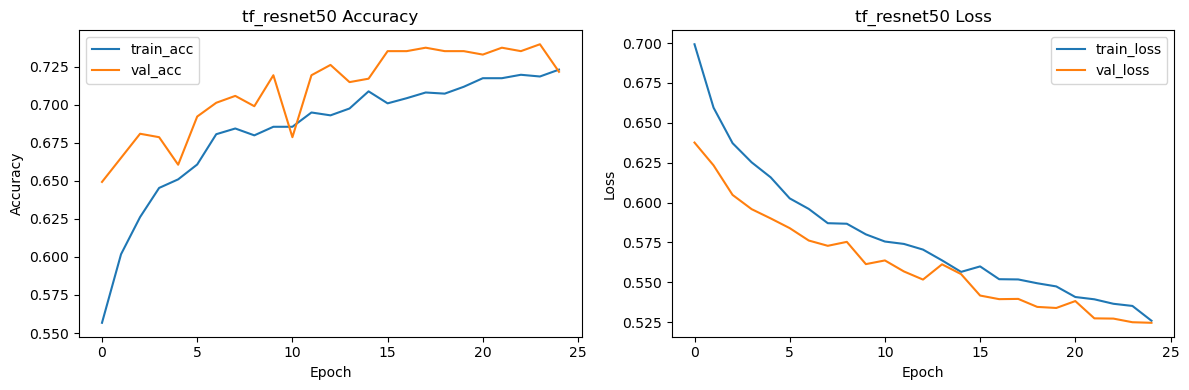

Saved curves to: ..\reports\tf_resnet50_training_curves.png


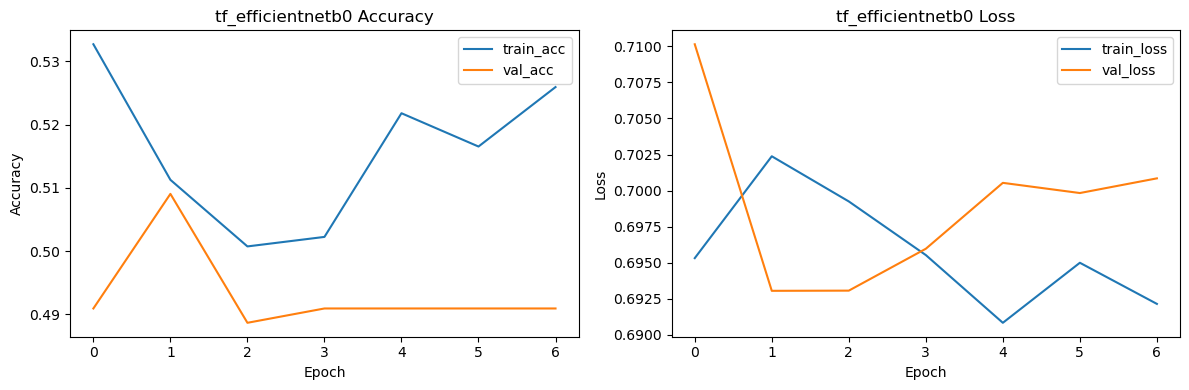

Saved curves to: ..\reports\tf_efficientnetb0_training_curves.png


In [12]:
def plot_and_save_history(history, model_name: str):
    hist = history.history

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()

    out_path = reports_dir / f"{model_name}_training_curves.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("Saved curves to:", out_path)

plot_and_save_history(resnet_history, "tf_resnet50")
plot_and_save_history(eff_history, "tf_efficientnetb0")


Base model name: resnet50
Total layers in base: 175
Fine-tuning from layer index: 145
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.7172 - loss: 0.6317 - precision: 0.7128 - recall: 0.6552
Epoch 1: val_accuracy improved from None to 0.54977, saving model to ..\models\tf_resnet50_finetuned_best.h5



Epoch 1: val_precision=1.0000, val_recall=0.1156, val_f1=0.2072
84/84 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7562 - loss: 0.5350 - precision: 0.7558 - recall: 0.7091 - val_accuracy: 0.5498 - val_loss: 1.4924 - val_precision: 1.0000 - val_recall: 0.1156
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8542 - loss: 0.3195 - precision: 0.8435 - recall: 0.8385
Epoch 2: val_accuracy improved from 0.54977 to 0.56335, saving model to ..\models\tf_resnet50_finetuned_best.h5



Epoch 2: val_precision=0.9706, val_recall=0.1467, val_f1=0.2548
84/84 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.8569 - loss: 0.3243 - precision: 0.8527 - recall: 0.8397 - val_accuracy: 0.5633 - val_loss: 1.9247 - val_precision: 0.9706 - val_recall: 0.1467
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9205 - loss: 0.2086 - precision: 0.9272 - recall: 0.8998
Epoch 3: val_accuracy improved from 0.56335 to 0.64027, saving model to ..\models\tf_resnet50_finetuned_best.h5



Epoch 3: val_precision=0.9853, val_recall=0.2978, val_f1=0.4573
84/84 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9102 - loss: 0.2245 - precision: 0.9132 - recall: 0.8934 - val_accuracy: 0.6403 - val_loss: 1.2235 - val_precision: 0.9853 - val_recall: 0.2978
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9267 - loss: 0.1797 - precision: 0.9229 - recall: 0.9252
Epoch 4: val_accuracy improved from 0.64027 to 0.76697, saving model to ..\models\tf_resnet50_finetuned_best.h5



Epoch 4: val_precision=0.9766, val_recall=0.5556, val_f1=0.7082
84/84 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9331 - loss: 0.1709 - precision: 0.9301 - recall: 0.9271 - val_accuracy: 0.7670 - val_loss: 0.6296 - val_precision: 0.9766 - val_recall: 0.5556
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9593 - loss: 0.1136 - precision: 0.9605 - recall: 0.9525
Epoch 5: val_accuracy improved from 0.76697 to 0.83258, saving model to ..\models\tf_resnet50_finetuned_best.h5



Epoch 5: val_precision=0.8953, val_recall=0.7600, val_f1=0.8221
84/84 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9606 - loss: 0.1121 - precision: 0.9613 - recall: 0.9543 - val_accuracy: 0.8326 - val_loss: 0.4232 - val_precision: 0.8953 - val_recall: 0.7600
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9667 - loss: 0.1004 - precision: 0.9727 - recall: 0.9582
Epoch 6: val_accuracy improved from 0.83258 to 0.85747, saving model to ..\models\tf_resnet50_finetuned_best.h5



Epoch 6: val_precision=0.8682, val_recall=0.8489, val_f1=0.8584
84/84 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9587 - loss: 0.1053 - precision: 0.9611 - recall: 0.9503 - val_accuracy: 0.8575 - val_loss: 0.4108 - val_precision: 0.8682 - val_recall: 0.8489
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.9687 - loss: 0.0873 - precision: 0.9637 - recall: 0.9679
Epoch 7: val_accuracy did not improve from 0.85747

Epoch 7: val_precision=0.7913, val_recall=0.8933, val_f1=0.8392
84/84 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9692 - loss: 0.0832 - precision: 0.9679 - recall: 0.9663 - val_accuracy: 0.8258 - val_loss: 0.4843 - val_precision: 0.7913 - val_recall: 0.8933
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.9695 - loss: 0.0894 - precision: 0.9691 - recall: 0.9656
Epoch 8: val_accuracy improved from 0.85747 to 0.86878, saving model to ..\models\tf_resnet50_finetuned_best.h5



Epoch 8: val_precision=0.8678, val_recall=0.8756, val_f1=0.8717
84/84 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9722 - loss: 0.0804 - precision: 0.9734 - recall: 0.9671 - val_accuracy: 0.8688 - val_loss: 0.3843 - val_precision: 0.8678 - val_recall: 0.8756
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9830 - loss: 0.0534 - precision: 0.9830 - recall: 0.9804
Epoch 9: val_accuracy did not improve from 0.86878

Epoch 9: val_precision=0.8768, val_recall=0.8222, val_f1=0.8486
84/84 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9745 - loss: 0.0688 - precision: 0.9712 - recall: 0.9744 - val_accuracy: 0.8507 - val_loss: 0.4655 - val_precision: 0.8768 - val_recall: 0.8222
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9666 - loss: 0.0847 - precision: 0.9691 - recall: 0.9598
Epoch 10: val_accuracy did not improve from 0.86878

Epoch 10: val_precision=0.8354, val_recall=0.9022, val_f1=0.8675
84/84 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9654 - 

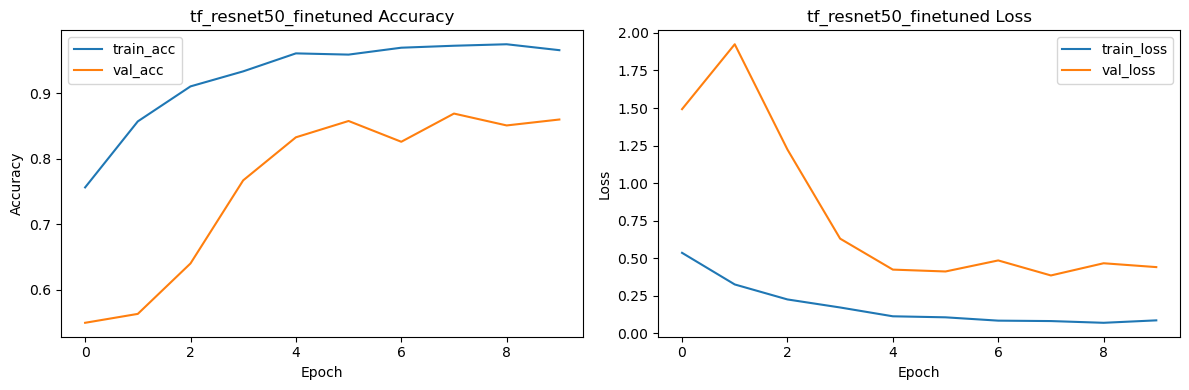

Saved curves to: ..\reports\tf_resnet50_finetuned_training_curves.png


In [15]:
# 1. Get the base ResNet model inside the full model
base_model = resnet_model.get_layer("resnet50")  # backbone name
print("Base model name:", base_model.name)
print("Total layers in base:", len(base_model.layers))

# 2. Decide how many layers to fine-tune (e.g. last 30)
fine_tune_at = len(base_model.layers) - 30
print("Fine-tuning from layer index:", fine_tune_at)

# 3. Freeze all layers before fine_tune_at, unfreeze the rest
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# 4. Re-compile with a smaller learning rate
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

# 5. Fine-tune
fine_history = resnet_model.fit(
    train_ds_norm,           # or train_ds_aug if you want
    validation_data=val_ds_norm,
    epochs=10,
    callbacks=get_callbacks("tf_resnet50_finetuned", val_ds_norm),
)

plot_and_save_history(fine_history, "tf_resnet50_finetuned")
